In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13,8)
#%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# APEX Gun example

In [4]:
import sys, os
root = os.path.join(os.getcwd(), '../')

sys.path.append(root)

GPT_IN = 'templates/apex_gun/gpt.in'
DISTGEN_IN = 'templates/apex_gun/distgen.yaml'

from gpt import GPT
from distgen import Generator

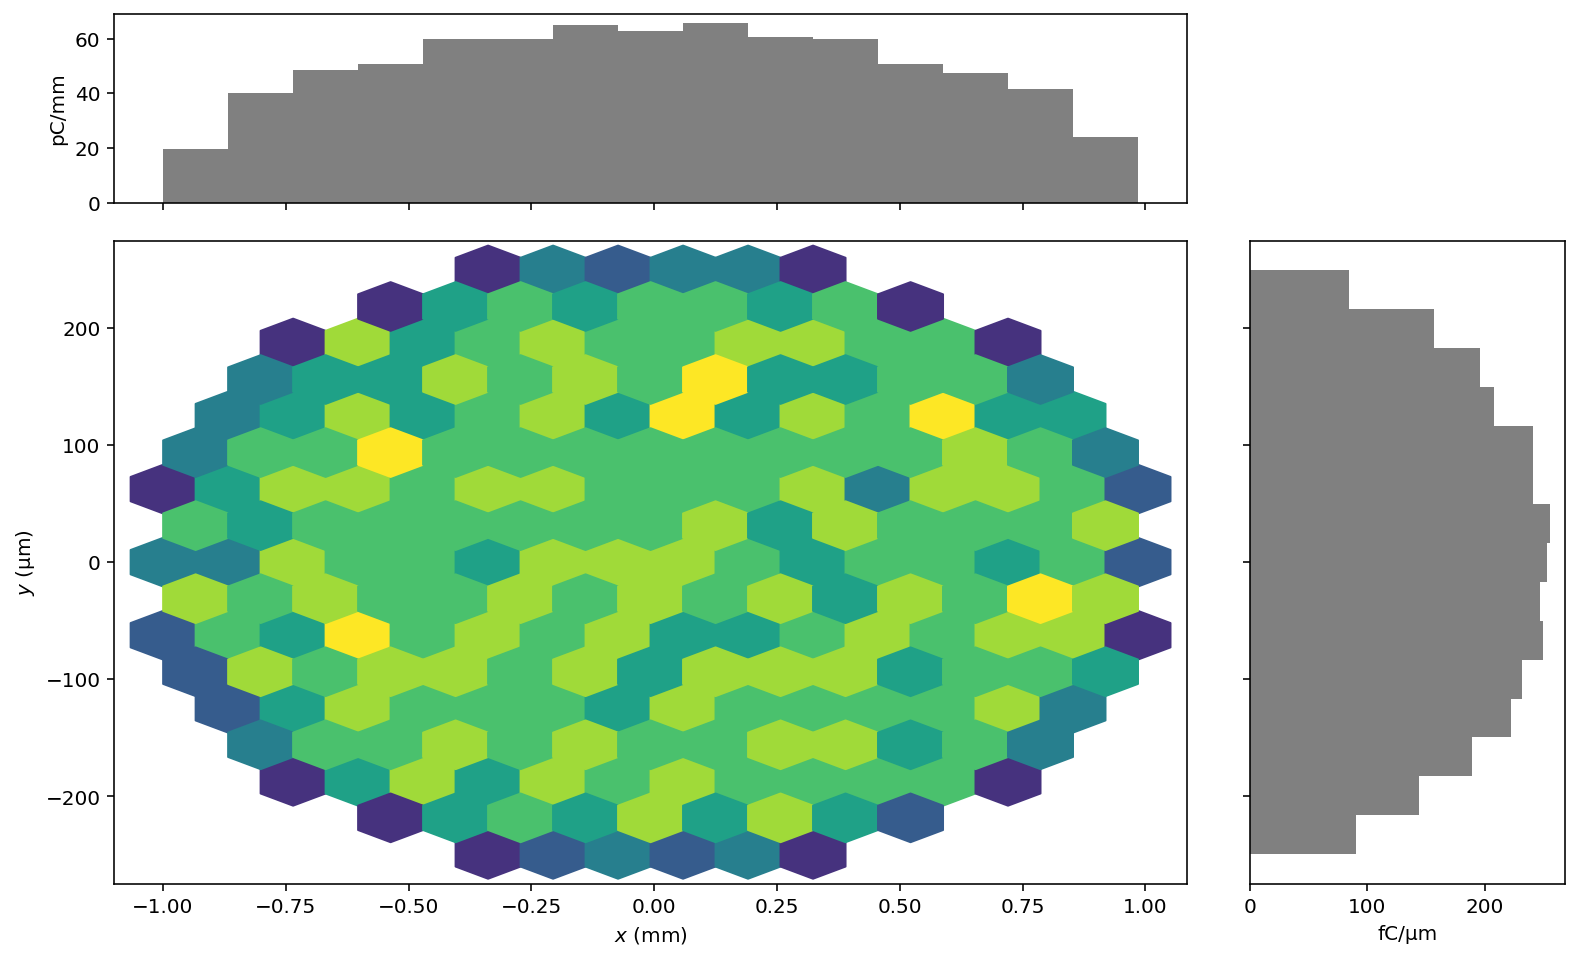

In [5]:
G = Generator(DISTGEN_IN)
G['n_particle'] = 1000

G.run()
P0 = G.particles
factor = 2
P0.x *= factor  
P0.y *= 1/factor 
P0.plot('x', 'y')

In [6]:
G = GPT(input_file=GPT_IN, initial_particles=P0, verbose=False)

In [ ]:
# Set some of these
variables_were_set = G.set_variables({'gun_peak_field':20e6,
                                      'gun_phase':0,
                                      'tmax': 5e-9, 
                                      'RadiusMax':.015,
                                      'Ntout':2000,
                                      'dtmin':0,
                                      'GBacc':6.5,
                                      'xacc':6.5,
                                      'space_charge':1})

In [11]:
# Run
G.run(gpt_verbose=False)

print(G)
print(G.screen)
#PF = G.screen[-1]
#len(G.particles), PF['mean_z'], PF['mean_kinetic_energy']/1e3




GPT object:
   Original input file: gpt.in
   Template location: /Users/colwyngulliford/Documents/GitHub/lume-gpt/examples/templates/apex_gun
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmp3mx9ayby
   Timeout: None (sec)

Results
   Finished: True
   Error occured: False
   Run time: 2.1547887325286865 (sec)
[]


In [ ]:
G.plot('sigma_x')

In [ ]:
G.plot(y=['norm_emit_x', 'norm_emit_y'], y2=['sigma_x', 'sigma_y'])

In [ ]:
G.particles[-1]

In [ ]:
import numpy as np

from pmd_beamphysics.particles import single_particle
P0 = single_particle()
G.initial_particles  = P0

def phaseit(phase):
    G.verbose=False
    G.set_variables({'gun_phase':phase})
    try:
        G.run()
        return G.particles[-1]['mean_kinetic_energy']/1e3
    except:
        return 0

In [ ]:
from scipy.optimize import brent

brent(lambda x: -phaseit(x%360), brack=(0, 360), maxiter=20, tol=1e-6, full_output=False) %360

In [ ]:
plist = np.linspace(170, 172, 10)
enlist = np.array([phaseit(p) for p in plist])

In [ ]:
plt.plot(plist, enlist)

# Plot trajectories

In [ ]:
G.particles[0]._settable_array_keys

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Make trajector structure here for now, should go somewhere else as a function



rs ={}
for t in G.particles:
    for ID in t['id']:
        idint=int(ID)
        res = np.where(t['id']==ID)
        index = res[0][0]
        
        if(ID not in rs.keys()):
            rs[idint]={'x':[],'y':[],'z':[], 't':[], 'GBz':[]}
        else:
            rs[idint]['x'].append(t['x'][index])
            rs[idint]['y'].append(t['y'][index])
            rs[idint]['z'].append(t['z'][index])
            rs[idint]['t'].append(t['t'][index])
          #  rs[idint]['GBz'].append(t['GBz'][index])
         

In [ ]:
for ind in rs.keys():
    for var in rs[ind]:
        rs[ind][var]=np.array(rs[ind][var])

for ind in rs.keys():
    plt.plot(rs[ind]['z'][0],rs[ind]['x'][0]*1e2, color='red', marker='o')
    plt.plot(rs[ind]['z'],rs[ind]['x']*1e2, color='black', alpha=0.1)

plt.ylim(-1.5, 1.5)
plt.xlim(0, 0.1)
plt.title('GPT tracking')
plt.xlabel('z (m)');
plt.ylabel('x (cm)');

In [ ]:
zlist = np.array([P['mean_z'] for P in G.particles])


In [ ]:
np.argmin(abs(zlist - 0.15))

In [ ]:
G.particles[3]['mean_z']

In [ ]:
#G.particles[3].write('$HOME/Scratch/gpt_apex_100pC_4x.h5')

In [ ]:
G.archive('gpt_apex_gun.h5')

In [ ]:
G2 = GPT()
G2.load_archive('gpt_apex_gun.h5')

In [ ]:
G2.particles[3]['mean_z']

In [ ]:
G.tout

In [ ]:
plt.plot(np.array([P['n_particle'] for P in G.particles]))